# Code for making predictions with and without news features

## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

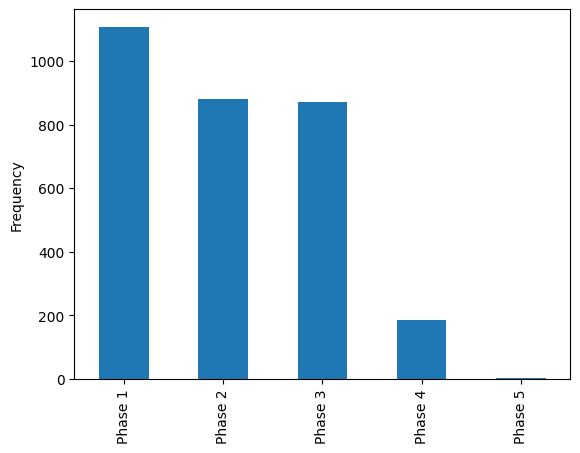

In [3]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

C:\Users\20203527\AppData\Local\Temp\ipykernel_28932\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


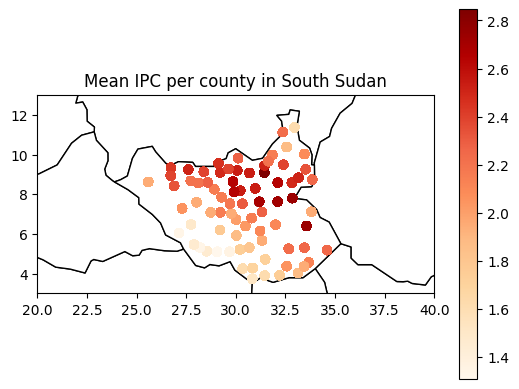

In [4]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [5]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [6]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [7]:
pd.set_option('display.max_columns', None) # Display all columns in DataFrame
df.head()

,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,114.3253,0.253903,-0.107226,0.671249,0.048880,0,0,0.561363,14008.33,7.961984,239344.0,11393.76,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,119.8153,1.018789,0.133927,0.129184,-0.457928,0,0,0.565693,14008.33,7.961984,239344.0,11393.76,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,110.3800,2.001045,-2.164728,1.025460,-0.590175,0,0,0.592437,14008.33,7.961984,239344.0,11393.76,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,102.3160,12.831140,-0.332849,3.846809,-1.845536,0,0,0.605352,14008.33,7.961984,239344.0,11393.76,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,97.1873,19.274320,0.288466,8.316274,-2.972735,0,0,0.618699,14008.33,7.961984,239344.0,11393.76,90.8503


In [8]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df # View the newly created columns

,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3
date,district,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,114.3253,0.253903,-0.107226,0.671249,0.048880,0,0,0.561363,14008.3300,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,119.8153,1.018789,0.133927,0.129184,-0.457928,0,0,0.565693,14008.3300,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,110.3800,2.001045,-2.164728,1.025460,-0.590175,0,0,0.592437,14008.3300,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,102.3160,12.831140,-0.332849,3.846809,-1.845536,0,0,0.605352,14008.3300,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,97.1873,19.274320,0.288466,8.316274,-2.972735,0,0,0.618699,14008.3300,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,Malakal,South Sudan,151,31.64280,9.658457,2019_10,2019,10,3.0,0.0,0.681990,113.3705,14.913800,2.580618,22.853360,6.053181,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000,0.000000,102.755628,2.096042,3.0,3.0,3.0
2019-11-01,Malakal,South Sudan,151,31.64280,9.658457,2019_11,2019,11,NaN,NaN,0.556748,116.7530,0.645686,-0.091687,13.372410,8.745254,0,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000,0.000000,103.497230,2.904992,NaN,NaN,NaN
2019-12-01,Malakal,South Sudan,151,31.64280,9.658457,2019_12,2019,12,NaN,NaN,0.400063,117.5583,0.046705,-0.000951,3.089540,1.698060,0,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000,0.000000,104.682503,3.090600,NaN,NaN,NaN


In [10]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  \
date       district                                                    
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611   
...                            ...   ...    ...  ...  ...        ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085   
           Yei             2020_02  2020      2  3.0  0.0   0.452878   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411   

                         ndvi_anom  rain_mean  rain_anom    et_mean   et_anom  \
date       district                                                             
2009-07-01 Abiemnhom      96.42507  21.596120  -6.204614  19.424150 -6.927661   
           Akobo          76.47572  18.402520 -12.032300  12.348940 -9.442238   
           Anzara        100.25750  22.977350  -5.924453  35.795540 -0.783660   
           Aweil Center   94.34696  28.023920  -5.272942  27.461880 -1.903216   
           Aweil East     86.30622  25.439220  -4.701670  14.422160 -4.741739   
...                            ...        ...        ...        ...       ...   
2020-02-01 Wulu          108.55950   0.665396  -0.278134   0.125452 -0.243994   
           Yambio        103.87600   1.465522  -1.156105   2.018053  0.066441   
           Yei           105.17720   2.409410  -0.666829   7.450696  4.531602   
           Yirol East    118.85030   0.488650  -0.015074   0.547773  0.065478   
           Yirol West    117.96820   0.574698  -0.129652   0.193867 -0.108897   

                         count_violence  sum_fatalities  food_price_idx  \
date       district                                                       
2009-07-01 Abiemnhom                  0               0        0.930064   
           Akobo                      2             161        1.011267   
           Anzara                     1               0        0.987558   
           Aweil Center               0               0        0.903080   
           Aweil East                 0               0        0.940368   
...                                 ...             ...             ...   
2020-02-01 Wulu                       1               1       83.059000   
           Yambio                     0               0       78.067220   
           Yei                        0               0       91.476050   
           Yirol East                 1               5      101.640400   
           Yirol West                 2              14      100.760300   

                              area  cropland_pct        pop  ruggedness_mean  \
date  

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 17 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        09:37:48   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

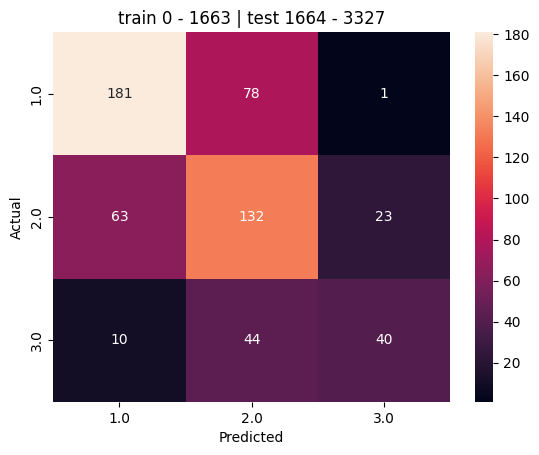

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     549.6
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:37:49   Log-Likelihood:                -1508.3
No. Observations:                2626   AIC:                             3031.
Df Residuals:                    2619   BIC:                             3072.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1836 

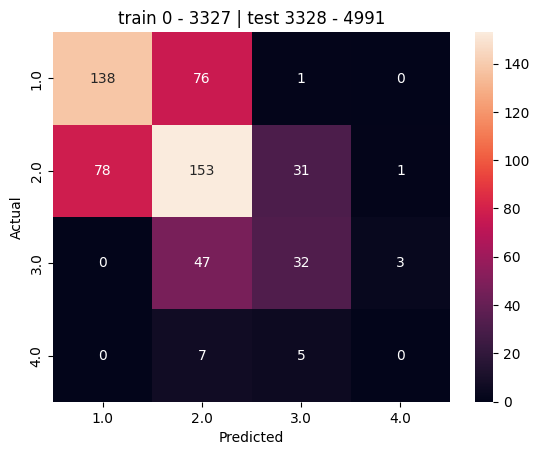

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     931.0
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:37:49   Log-Likelihood:                -2591.1
No. Observations:                4290   AIC:                             5196.
Df Residuals:                    4283   BIC:                             5241.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2779 

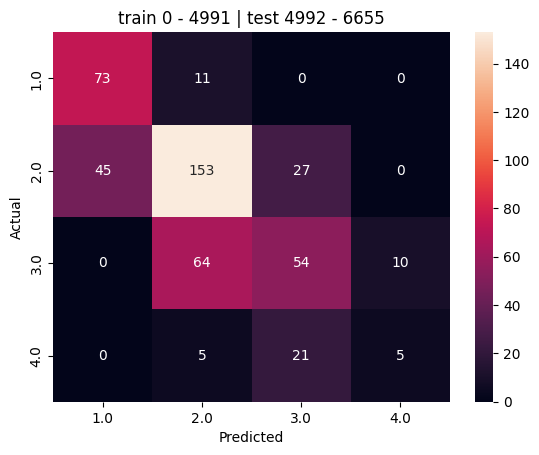

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:37:50   Log-Likelihood:                -3594.1
No. Observations:                5954   AIC:                             7202.
Df Residuals:                    5947   BIC:                             7249.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2726 

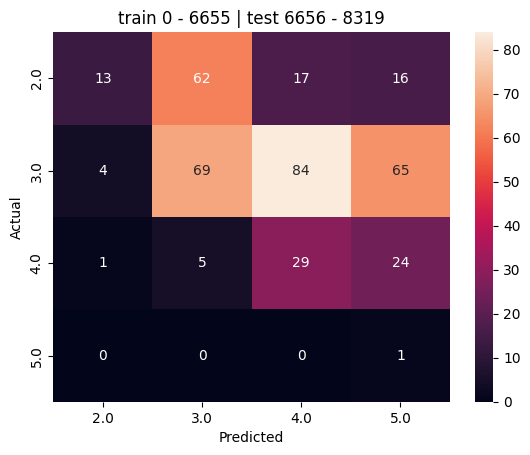

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2985.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:37:51   Log-Likelihood:                -4798.7
No. Observations:                7618   AIC:                             9611.
Df Residuals:                    7611   BIC:                             9660.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2922 

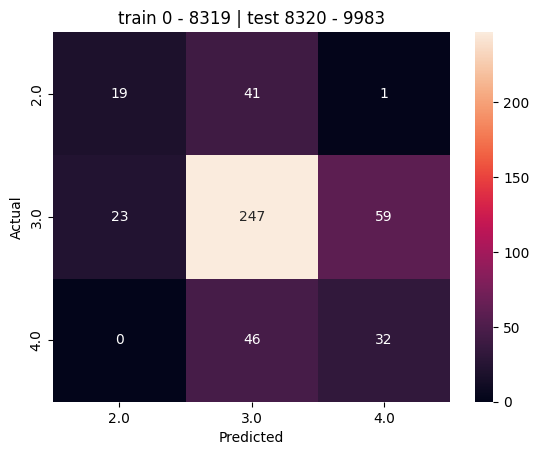

Mean MAE: 0.59
Mean R2: 0.62


<Figure size 640x480 with 0 Axes>

In [14]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [15]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,True
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,False


In [16]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

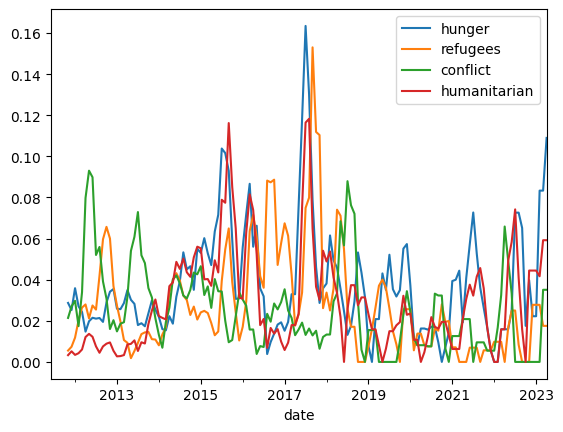

In [17]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

news_features.plot();

In [18]:
news_features

,hunger,refugees,conflict,humanitarian
date,,,,
2011-06-01,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-12-01,0.022222,0.027778,4.625929e-18,0.044444
2023-01-01,0.022222,0.027778,4.625929e-18,0.044444
2023-02-01,0.083333,0.027778,4.625929e-18,0.041667


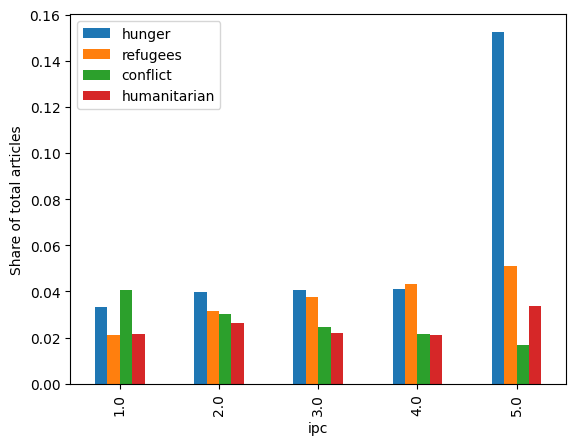

In [19]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [20]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [22]:
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  \
date       district                                                    
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611   
...                            ...   ...    ...  ...  ...        ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085   
           Yei             2020_02  2020      2  3.0  0.0   0.452878   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411   

                         ndvi_anom  rain_mean  rain_anom    et_mean   et_anom  \
date       district                                                             
2009-07-01 Abiemnhom      96.42507  21.596120  -6.204614  19.424150 -6.927661   
           Akobo          76.47572  18.402520 -12.032300  12.348940 -9.442238   
           Anzara        100.25750  22.977350  -5.924453  35.795540 -0.783660   
           Aweil Center   94.34696  28.023920  -5.272942  27.461880 -1.903216   
           Aweil East     86.30622  25.439220  -4.701670  14.422160 -4.741739   
...                            ...        ...        ...        ...       ...   
2020-02-01 Wulu          108.55950   0.665396  -0.278134   0.125452 -0.243994   
           Yambio        103.87600   1.465522  -1.156105   2.018053  0.066441   
           Yei           105.17720   2.409410  -0.666829   7.450696  4.531602   
           Yirol East    118.85030   0.488650  -0.015074   0.547773  0.065478   
           Yirol West    117.96820   0.574698  -0.129652   0.193867 -0.108897   

                         count_violence  sum_fatalities  food_price_idx  \
date       district                                                       
2009-07-01 Abiemnhom                  0               0        0.930064   
           Akobo                      2             161        1.011267   
           Anzara                     1               0        0.987558   
           Aweil Center               0               0        0.903080   
           Aweil East                 0               0        0.940368   
...                                 ...             ...             ...   
2020-02-01 Wulu                       1               1       83.059000   
           Yambio                     0               0       78.067220   
           Yei                        0               0       91.476050   
           Yirol East                 1               5      101.640400   
           Yirol West                 2              14      100.760300   

                              area  cropland_pct        pop  ruggedness_mean  \
date  

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 17 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        09:41:03   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

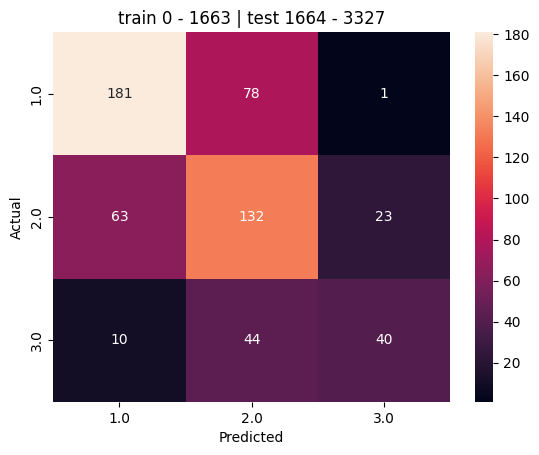

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     248.5
Date:                Tue, 17 Oct 2023   Prob (F-statistic):          2.22e-277
Time:                        09:41:04   Log-Likelihood:                -559.15
No. Observations:                1144   AIC:                             1140.
Df Residuals:                    1133   BIC:                             1196.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2510 

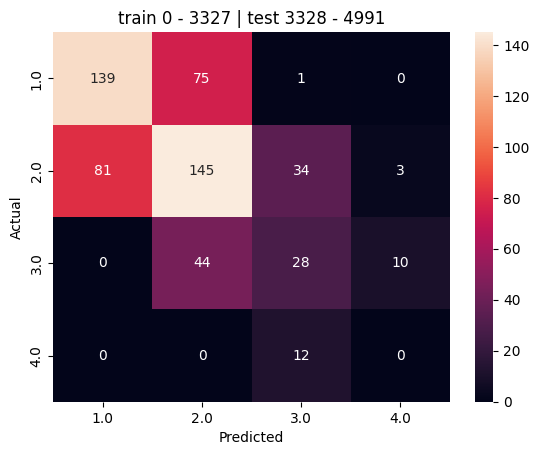

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     457.2
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:41:04   Log-Likelihood:                -1638.5
No. Observations:                2808   AIC:                             3299.
Df Residuals:                    2797   BIC:                             3364.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4259 

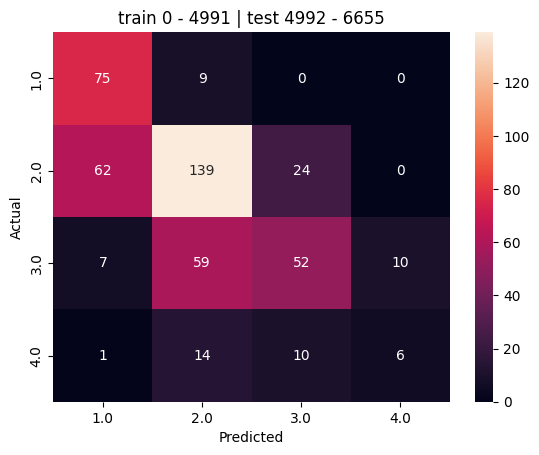

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     888.1
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:41:05   Log-Likelihood:                -2711.2
No. Observations:                4472   AIC:                             5444.
Df Residuals:                    4461   BIC:                             5515.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5152 

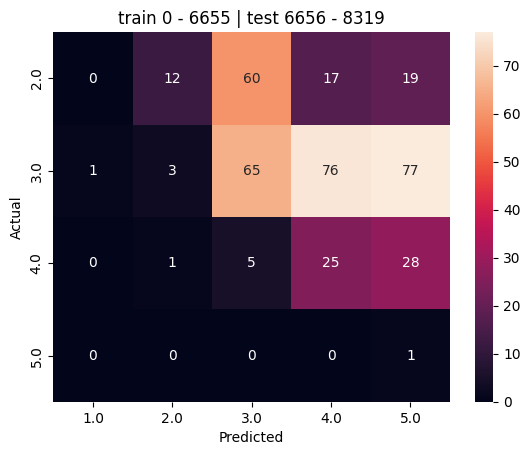

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1445.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:41:05   Log-Likelihood:                -3927.1
No. Observations:                6136   AIC:                             7876.
Df Residuals:                    6125   BIC:                             7950.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3488 

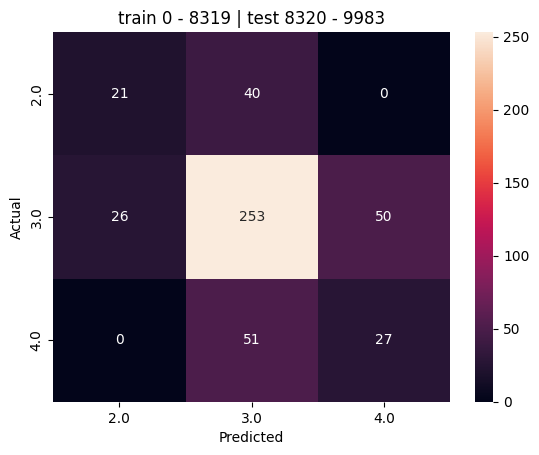

Mean MAE: 0.62
Mean R2: 0.66


<Figure size 640x480 with 0 Axes>

In [23]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [16]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.7213
Time:                        14:08:23   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

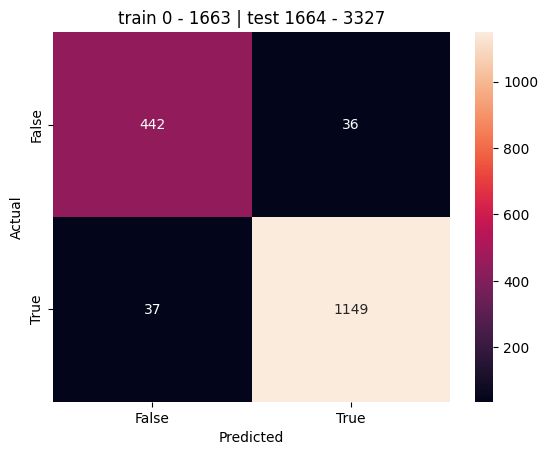

Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                          Logit   Df Residuals:                     2622
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.4129
Time:                        14:08:24   Log-Likelihood:                -516.04
converged:                       True   LL-Null:                       -878.95
Covariance Type:            nonrobust   LLR p-value:                5.241e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0771      0.344    -23.471      0.000      -8.752      -7.403
ipc_lag_1      3.0044      0.

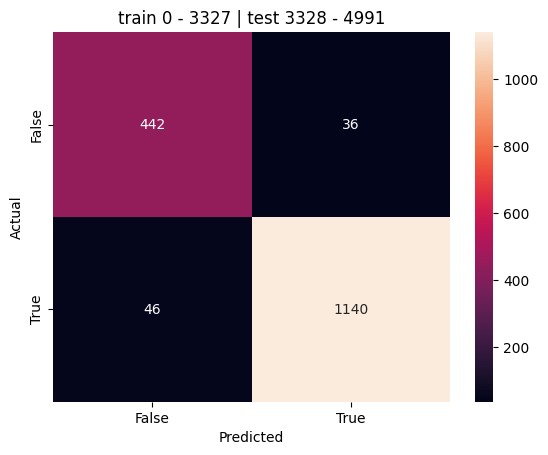

Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                          Logit   Df Residuals:                     4286
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.3941
Time:                        14:08:24   Log-Likelihood:                -947.83
converged:                       True   LL-Null:                       -1564.4
Covariance Type:            nonrobust   LLR p-value:                4.853e-267
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8526      0.262    -29.949      0.000      -8.367      -7.339
ipc_lag_1      2.9520      0.

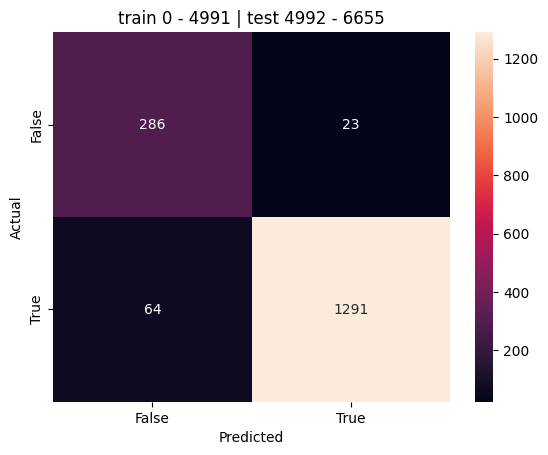

Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                          Logit   Df Residuals:                     5950
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.4349
Time:                        14:08:24   Log-Likelihood:                -1569.1
converged:                       True   LL-Null:                       -2776.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8860      0.209    -37.780      0.000      -8.295      -7.477
ipc_lag_1      2.8618      0.

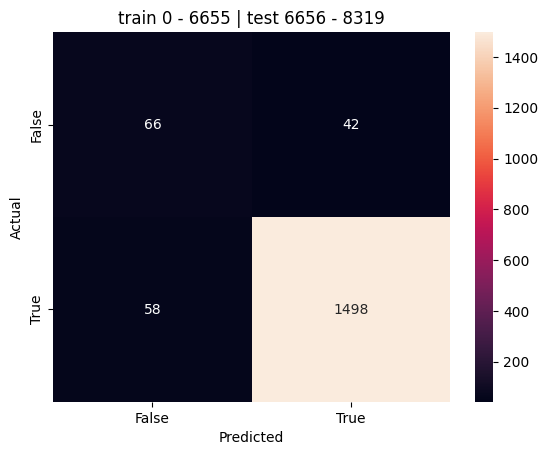

Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                          Logit   Df Residuals:                     7614
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.5120
Time:                        14:08:25   Log-Likelihood:                -2267.6
converged:                       True   LL-Null:                       -4646.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2706      0.182    -45.491      0.000      -8.627      -7.914
ipc_lag_1      2.6647      0.

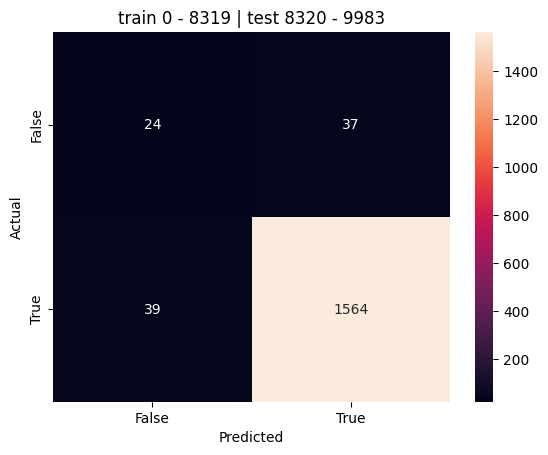

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [17]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc